None                                               | id: r_1, start: 0, -2.5, end: 10, -2.5
id: r_2, start: 0, -5, end: 10, -5                 | id: r_3, start: 3, -7.5, end: 10, -7.5
id: r_4, start: 3, -10, end: 7, -10                | None
id: r_3, start: 3, -7.5, end: 10, -7.5             | id: r_4, start: 3, -10, end: 7, -10
id: r_1, start: 0, -2.5, end: 10, -2.5             | id: r_2, start: 0, -5, end: 10, -5
approach: 12.0, -1.25, path: start: 11.0, -1.25, end: -1.0, -1.25, left id: r_1, right id: None
approach: -2.0, -6.25, path: start: -1.0, -6.25, end: 11.0, -6.25, left id: r_2, right id: r_3
approach: 9.0, -11.25, path: start: 8.0, -11.25, end: 2.0, -11.25, left id: None, right id: r_4
approach: 1.0, -8.75, path: start: 2.0, -8.75, end: 11.0, -8.75, left id: r_3, right id: r_4
approach: 12.0, -3.75, path: start: 11.0, -3.75, end: -1.0, -3.75, left id: r_2, right id: r_1
5.0
5.0
5.0
6.5
5.0


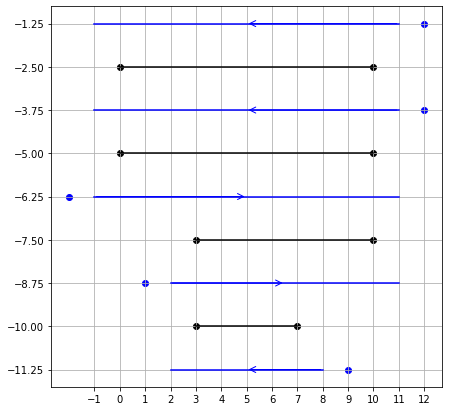

In [117]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]
from geometry_msgs.msg import Point

def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
        print(position)
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[0], ydata[0]),
        xy=(xdata.mean(), ydata.mean()),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )

class Row:
    def __init__(self, start, end, id):
        self.start = start
        self.end = end
        self.id = id

    def __str__(self):
        return f"id: {self.id}, start: {self.start.x}, {self.start.y}, end: {self.end.x}, {self.end.y}"

class RowPath:
    def __init__(self, start, end, left, right):
        self.start = start
        self.end = end
        self.left = left
        self.right = right

    def __str__(self):
        left_id = self.left.id if self.left is not None else 'None'
        right_id = self.right.id if self.right is not None else 'None'
        return f"start: {self.start.x}, {self.start.y}, end: {self.end.x}, {self.end.y}, left id: {left_id}, right id: {right_id}"

real_rows = [
    Row(Point(x=0, y=-2.5), Point(x=10, y=-2.5), 'r_1'),
    Row(Point(x=0, y=-5), Point(x=10, y=-5), 'r_2'),
    Row(Point(x=3, y=-7.5), Point(x=10, y=-7.5), 'r_3'),
    Row(Point(x=3, y=-10), Point(x=7, y=-10), 'r_4'),
]

### params

alternate = True
switch_direction = True

row_path_external_dist = 2.5/2
row_path_margin = 1.0
row_approach_margin = 1.0

###

rows = [None] + real_rows + [None]
row_pairs = list(zip(rows[0:-1], rows[1:]))

if alternate:
    row_pairs = row_pairs[::2] + row_pairs[1::2][::-1]
for r_1, r_2 in row_pairs:
    print(f"{str(r_1):<50} | {r_2}")

row_paths = list()
row_approaches = list()
for i, (r_1, r_2) in enumerate(row_pairs):
    discordant_direction = (i + switch_direction) % 2
    if discordant_direction:
        # path goes from row's end to start
        if r_1 is not None and r_2 is not None:
            p = RowPath(
                start=Point(x=max(r_1.end.x, r_2.end.x) + row_path_margin, y=(r_1.end.y + r_2.end.y)/2),
                end=Point(x=min(r_1.start.x, r_2.start.x) - row_path_margin, y=(r_1.start.y + r_2.start.y)/2),
                left=r_2,
                right=r_1,
            )
        elif r_1 is None:  # first row pair (even)
            p = RowPath(
                start=Point(x=r_2.end.x + row_path_margin, y=r_2.end.y + row_path_external_dist),
                end=Point(x=r_2.start.x - row_path_margin, y=r_2.start.y + row_path_external_dist),
                left=r_2,
                right=r_1,
            )
        elif r_2 is None:  # last row pair (even)
            p = RowPath(
                start=Point(x=r_1.end.x + row_path_margin, y=r_1.end.y - row_path_external_dist),
                end=Point(x=r_1.start.x - row_path_margin, y=r_1.start.y - row_path_external_dist),
                left=r_2,
                right=r_1,
            )
        a = Point(x=p.start.x + row_approach_margin, y=p.start.y)
    else:
        # path goes from row's start to end
        if r_1 is not None and r_2 is not None:
            p = RowPath(
                start=Point(x=min(r_1.start.x, r_2.start.x) - row_path_margin, y=(r_1.start.y + r_2.start.y)/2),
                end=Point(x=max(r_1.end.x, r_2.end.x) + row_path_margin, y=(r_1.end.y + r_2.end.y)/2),
                left=r_1,
                right=r_2,
            )
        elif r_1 is None:  # first row pair (always odd)
            p = RowPath(
                start=Point(x=r_2.start.x - row_path_margin, y=r_2.start.y + row_path_external_dist),
                end=Point(x=r_2.end.x + row_path_margin, y=r_2.end.y + row_path_external_dist),
                left=r_1,
                right=r_2,
            )
        elif r_2 is None:  # last row pair (odd)
            p = RowPath(
                start=Point(x=r_1.start.x - row_path_margin, y=r_1.start.y - row_path_external_dist),
                end=Point(x=r_1.end.x + row_path_margin, y=r_1.end.y - row_path_external_dist),
                left=r_1,
                right=r_2,
            )
        a = Point(x=p.start.x - row_approach_margin, y=p.start.y)
    row_paths.append(p)
    row_approaches.append(a)
    print(f"approach: {a.x}, {a.y}, path: {p}")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_yticks(np.arange(-5*2*1.25, 0, 1.25))
ax.set_xticks(np.arange(-1, 13, 1.0))
plt.grid()

for r in real_rows:
    plt.plot([r.start.x, r.end.x], [r.start.y, r.end.y], color='black')
    plt.scatter([r.start.x, r.end.x], [r.start.y, r.end.y], color='black')

for a in row_approaches:
    plt.scatter([a.x], [a.y], color='blue')

for p in row_paths:
    line = plt.plot([p.start.x, p.end.x], [p.start.y, p.end.y], color='blue')[0]
    add_arrow(line)

plt.show()
